In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:

# #Installing Basemap 
# # Comment out the following code if need to re-install -
 
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
     \ 149.0MB 1.7MB/s
     |████████████████████████████████| 6.5MB 4.2MB/s 
     |████████████████████████████████| 225kB 42.3MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [ ]:
data     = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CDS Group Project/flights.csv')
airports = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CDS Group Project/airports.csv")
airlines = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CDS Group Project/airlines.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Removing CANCELLED Flights
delay_data = data[data['CANCELLED'] == 0].copy()

# Dropping irrelevant Columns
delay_data = delay_data.drop(columns = ['CANCELLED','CANCELLATION_REASON'])

# Removing DELAYED Flights
delay_data = delay_data[delay_data['DIVERTED'] == 0].copy()

# Filling NaN with 0 -
delay_data.iloc[:,-5:] = delay_data.iloc[:,-5:].copy().fillna(0)

# Creating a New DELAYED binary feature for all flights delayed by more than 15 minutes
delay_data.loc[delay_data['ARRIVAL_DELAY'] >= 15,'DELAYED'] = 1
delay_data.loc[delay_data['ARRIVAL_DELAY'] < 15,'DELAYED'] = 0

# Dropping irrelevant columns
delay_data = delay_data.drop(columns = ['YEAR','FLIGHT_NUMBER','TAIL_NUMBER','TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN','DIVERTED'])

In [ ]:
delay_data.head()

MONTH  DAY  DAY_OF_WEEK  ... LATE_AIRCRAFT_DELAY WEATHER_DELAY DELAYED
0      1    1            4  ...                 0.0           0.0     0.0
1      1    1            4  ...                 0.0           0.0     0.0
2      1    1            4  ...                 0.0           0.0     0.0
3      1    1            4  ...                 0.0           0.0     0.0
4      1    1            4  ...                 0.0           0.0     0.0

[5 rows x 22 columns]

In [ ]:
latlong_origin = {'LATITUDE':'ORIGIN_LAT','LONGITUDE':'ORIGIN_LONG'}
latlong_destin = {'LATITUDE':'DESTINATION_LAT','LONGITUDE':'DESTINATION_LONG'}

# Joining AIRPORTS and DELAY_DATA dataframes -
temp1 = pd.merge(delay_data,airports, how="left", left_on="ORIGIN_AIRPORT", right_on="IATA_CODE")
temp1 = temp1.rename(columns = latlong_origin).copy()
temp1 = temp1.drop(columns = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY'])

temp2 = pd.merge(temp1,airports, how="left", left_on="DESTINATION_AIRPORT", right_on="IATA_CODE")
temp2 = temp2.rename(columns = latlong_destin).copy()
temp2 = temp2.drop(columns = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY'])

temp2 = temp2[temp2['DESTINATION_LONG'].notnull()].copy()
temp2 = temp2[temp2['ORIGIN_LONG'].notnull()].copy()

df    = temp2.copy() # df is the dataframe object with Lat/Long values of ORIGIN + Desitination added

In [ ]:
delay_data.shape

(5714008, 22)

In [ ]:
# Testing for LAT and LONGitude for a given route -
x = df[df['AIRLINE'] == 'AS'][['ORIGIN_LAT','ORIGIN_LONG','DESTINATION_LAT','DESTINATION_LONG','ORIGIN_AIRPORT','DESTINATION_AIRPORT']]. \
    groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'], as_index = False).mean()

In [ ]:
x.head()

ORIGIN_AIRPORT DESTINATION_AIRPORT  ...  DESTINATION_LAT  DESTINATION_LONG
0            ABQ                 SEA  ...         47.44898        -122.30931
1            ADK                 ANC  ...         61.17432        -149.99619
2            ADQ                 ANC  ...         61.17432        -149.99619
3            AKN                 ANC  ...         61.17432        -149.99619
4            ANC                 ADK  ...         51.87796        -176.64603

[5 rows x 6 columns]

In [ ]:
# Temp variable to aggregate count of flights, delayed flightts and sum of arrival delay of flights
temp = df[df['AIRLINE'] == 'AS'][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DELAYED','ARRIVAL_DELAY','MONTH']]. \
    groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'], as_index = False).agg({'MONTH':'count',
                                                                             'DELAYED':lambda x: x.sum(),
                                                                             'ARRIVAL_DELAY':lambda x: x[x>0].sum()})

In [ ]:
temp = temp.rename(columns = {'MONTH':'Count of Flights'},)
temp.sort_values('ARRIVAL_DELAY')

ORIGIN_AIRPORT DESTINATION_AIRPORT  ...  DELAYED  ARRIVAL_DELAY
14             ANC                 KOA  ...      1.0           39.0
44             CHS                 SEA  ...      1.0           51.0
177            SEA                 CHS  ...      2.0           69.0
22             ANC                 PHX  ...      3.0          134.0
147            PHX                 ANC  ...      3.0          156.0
..             ...                 ...  ...      ...            ...
94             LAX                 SEA  ...    618.0        33355.0
222            SFO                 SEA  ...    530.0        34136.0
211            SEA                 SFO  ...    599.0        35219.0
169            SEA                 ANC  ...    759.0        36088.0
194            SEA                 LAX  ...    784.0        39242.0

[251 rows x 5 columns]

In [ ]:
temp.shape

(251, 5)

In [ ]:
xtemp = pd.DataFrame()
for i in range(temp.shape[0]-1):
  
  temprow = temp[i:i+1].copy()
  a1 = temprow.iloc[0,0]
  a2 = temprow.iloc[0,1]
  for j in range(i+1, temp.shape[0]):
    if a1 == temp.iloc[j,1]:
      if a2 == temp.iloc[j,0]:
        temprow.iloc[0,2] += temp.iloc[j,2]
        temprow.iloc[0,3] += temp.iloc[j,3]
        temprow.iloc[0,4] += temp.iloc[j,4]
        xtemp = pd.concat([xtemp,temprow])
        break

In [ ]:
(xtemp['DELAYED']/xtemp['Count of Flights']).head(20)

0     0.049550
1     0.276836
2     0.117849
3     0.190476
7     0.134736
8     0.120553
9     0.151376
10    0.071429
11    0.122490
12    0.100365
13    0.151663
14    0.056818
15    0.095238
16    0.087927
17    0.136364
18    0.178270
19    0.130137
20    0.155047
21    0.069301
22    0.040268
dtype: float64

In [ ]:
(temp['DELAYED']/temp['Count of Flights']).head(20)

0     0.054217
1     0.420455
2     0.130435
3     0.222222
4     0.134831
5     0.105263
6     0.158730
7     0.128555
8     0.147541
9     0.136778
10    0.051948
11    0.171171
12    0.080586
13    0.117073
14    0.022727
15    0.071429
16    0.094488
17    0.107692
18    0.113573
19    0.115646
dtype: float64

In [ ]:
temp[(temp['ORIGIN_AIRPORT'] == 'SEA') | (temp['DESTINATION_AIRPORT'] == 'SEA')]

ORIGIN_AIRPORT DESTINATION_AIRPORT  ...  DELAYED  DEPARTURE_DELAY
0              ABQ                 SEA  ...     18.0            793.0
24             ANC                 SEA  ...    471.0          20448.0
25             ATL                 SEA  ...     64.0           3405.0
26             AUS                 SEA  ...     57.0           4873.0
31             BLI                 SEA  ...     31.0           1433.0
..             ...                 ...  ...      ...              ...
241            SMF                 SEA  ...    209.0           8730.0
243            SNA                 SEA  ...    222.0          10253.0
244            STL                 SEA  ...     70.0           3331.0
245            TPA                 SEA  ...     71.0           3482.0
246            TUS                 SEA  ...     25.0           1285.0

[104 rows x 5 columns]

In [ ]:
df[df['AIRLINE'] == 'AS'][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','ORIGIN_LAT']]. \
    groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'], as_index = False).count()

ORIGIN_AIRPORT DESTINATION_AIRPORT  ORIGIN_LAT
0              ABQ                 SEA         332
1              ADK                 ANC          88
2              ADQ                 ANC         437
3              AKN                 ANC          63
4              ANC                 ADK          89
..             ...                 ...         ...
246            TUS                 SEA         346
247            WRG                 KTN         324
248            WRG                 PSG         325
249            YAK                 CDV         325
250            YAK                 JNU         325

[251 rows x 3 columns]

In [ ]:
airline_name = ['AS', 'AA', 'US', 'DL', 'NK', 'UA', 'HA', 'B6', 'OO', 'EV', 'F9', 'WN', 'MQ', 'VX']
df['AIRLINE'].unique()

array(['AS', 'AA', 'US', 'DL', 'NK', 'UA', 'HA', 'B6', 'OO', 'EV', 'F9',
       'WN', 'MQ', 'VX'], dtype=object)

In [ ]:
# Function to instantiate a basemap object
def make_map(x, airline):
  m = Basemap(projection='mill',llcrnrlat=15,urcrnrlat=75, llcrnrlon=-170,urcrnrlon=-60,resolution='c')
  m.drawcoastlines()
  m.fillcontinents(color='grey')
  m.drawcountries(color='black')
  m.drawstates(color='black')

  lat = x['ORIGIN_LAT']; lon = x['ORIGIN_LONG']
  xpt,ypt = m(lon,lat)  # convert to map projection coords.
  lonpt, latpt = m(xpt,ypt,inverse=True)  # convert back to lat/lon
  m.plot(xpt,ypt,'bo')  # plot blue dots there
  return m

In [ ]:
# function to draw routes (greatcircles)
def plot_great_circles(xval,breaks,m):
  for i in range(xval.shape[0]):
    if xval[i][4] >= breaks[0]:
      m.drawgreatcircle(xval[i][1],xval[i][0],xval[i][3],xval[i][2],linewidth=1,color='r')
    elif xval[i][4] >= breaks[1]:
      m.drawgreatcircle(xval[i][1],xval[i][0],xval[i][3],xval[i][2],linewidth=1,color='y')
    elif xval[i][4] >= breaks[2]:
      m.drawgreatcircle(xval[i][1],xval[i][0],xval[i][3],xval[i][2],linewidth=1,color='g')
    elif xval[i][4] >= breaks[3]:
      m.drawgreatcircle(xval[i][1],xval[i][0],xval[i][3],xval[i][2],linewidth=1,color='b')

In [ ]:
# Function to plot 1. Traffic, 2. Priportion of delayed flights, and 3. Mean delay times per route
def traffic_delay_time_plot(df, airline):

  fig = plt.figure(figsize=(22, 5.5))

  #xxxxxxxxxxxxxxxxx---Airline-Route Wise Traffic Plot---xxxxxxxxxxxxxxxxx#
  plt.subplot(1,3,1) 
  plt.title('Traffic', size = 18)

  x1 = df[df['AIRLINE'] == airline][['ORIGIN_LAT','ORIGIN_LONG','DESTINATION_LAT','DESTINATION_LONG','ORIGIN_AIRPORT']].\
    groupby(['ORIGIN_LAT','ORIGIN_LONG','DESTINATION_LAT','DESTINATION_LONG'], as_index = False).count()
  m = make_map(x1, airline)
  
  xval = x1.values
  breaks = [1000, 500, 250, 0] # breaks for paritioning number of flights per route into bins -
  plot_great_circles(xval, breaks, m)

  #xxxxxxxxxxxxxxxxx---Airline-Proportion of Flights Delayed Route Wise Plot---xxxxxxxxxxxxxxxxx#
  plt.subplot(1,3,2)
  plt.title('Proportion of Delayed Flights', size = 18)

  x2 = df[df['AIRLINE'] == airline][['ORIGIN_LAT','ORIGIN_LONG','DESTINATION_LAT','DESTINATION_LONG','DELAYED']].\
    groupby(['ORIGIN_LAT','ORIGIN_LONG','DESTINATION_LAT','DESTINATION_LONG'], as_index = False).mean()
  m = make_map(x2, airline)

  xval = x2.values
  breaks = [0.5, 0.25, 0.125, 0] # breaks for partitioning proportion of delayed flights per route into bins -
  plot_great_circles(xval, breaks, m)
  
  #xxxxxxxxxxxxxxxxx---Airline-Mean Delay Time Route Wise Plot---xxxxxxxxxxxxxxxxx#
  plt.subplot(1,3,3)
  plt.title('Mean Delay Time of Delayed Flights', size = 18)

  x3 = df[df['AIRLINE'] == airline][['ORIGIN_LAT','ORIGIN_LONG','DESTINATION_LAT','DESTINATION_LONG','ARRIVAL_DELAY']].\
    groupby(['ORIGIN_LAT','ORIGIN_LONG','DESTINATION_LAT','DESTINATION_LONG'], as_index = False).mean()
  m = make_map(x3, airline)

  xval = x3.values
  breaks = [30,20,10,5] # breaks for paritioning mean delay time of flights per route into bins -
  plot_great_circles(xval, breaks, m)

  plt.suptitle(airlines[airlines['IATA_CODE'] == airline].iloc[0,1], size = 26)


In [ ]:
"""
NOTE:
In below plots - 
RED: Highes Traffic / Highest Delay Routes
YELLOW...
GREEN...
BLUE: Lowest Traffic/Delay Routes

For "Mean Delay Time of Delayed Flights" chart, only routes with mean delay time > 10 minutes have been plotted.
"""

'\nNOTE:\nIn below plots - \nRED: Highes Traffic / Highest Delay Routes\nYELLOW...\nGREEN...\nBLUE: Lowest Traffic/Delay Routes\n\nFor "Mean Delay Time of Delayed Flights" chart, only routes with mean delay time > 10 minutes have been plotted.\n'

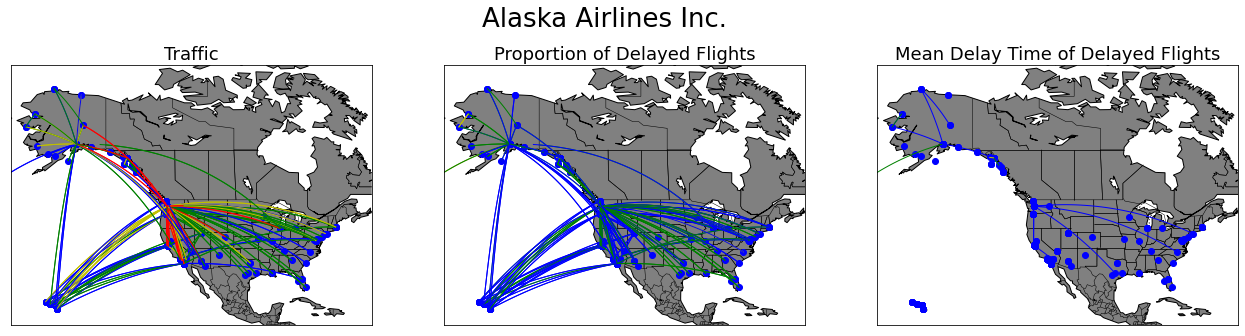

In [ ]:
traffic_delay_time_plot(df,'AS')

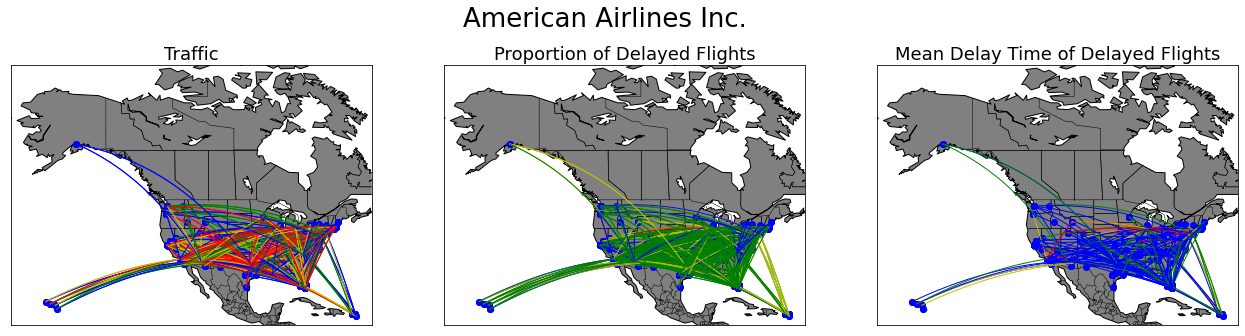

In [ ]:
traffic_delay_time_plot(df,'AA')

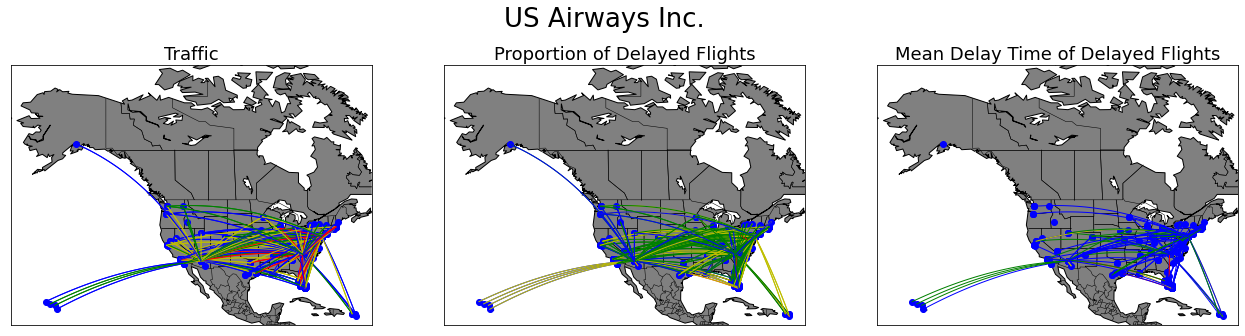

In [ ]:
traffic_delay_time_plot(df,'US')

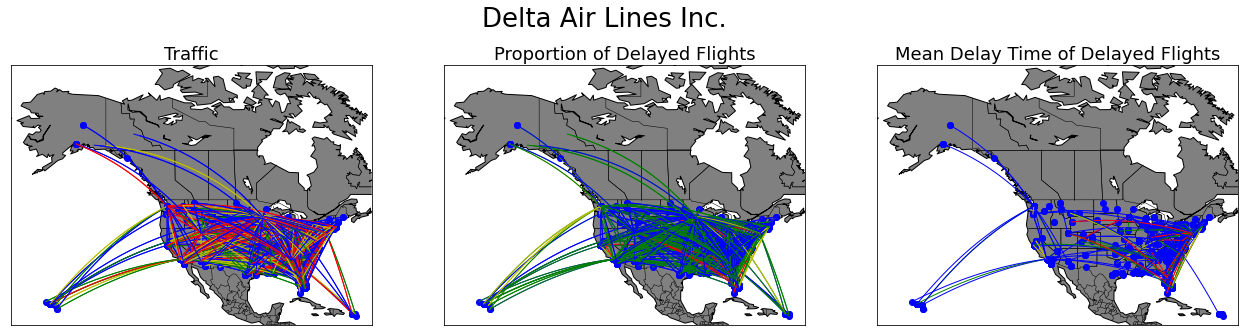

In [ ]:
traffic_delay_time_plot(df,'DL')

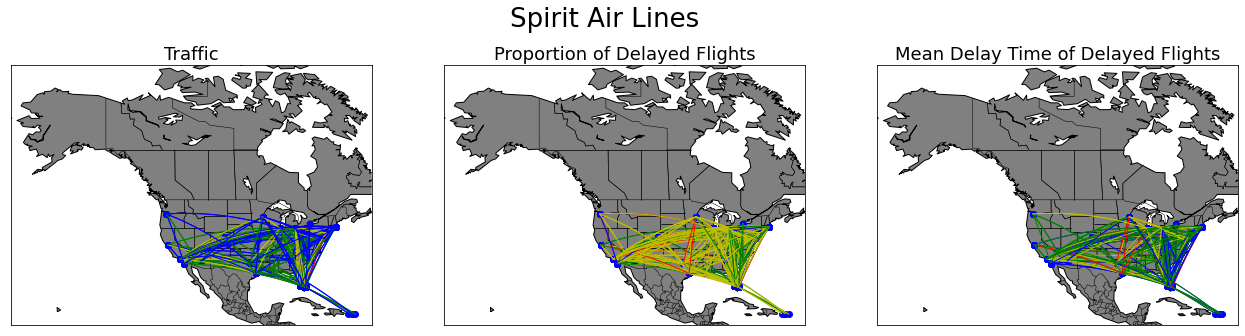

In [ ]:
traffic_delay_time_plot(df,'NK')

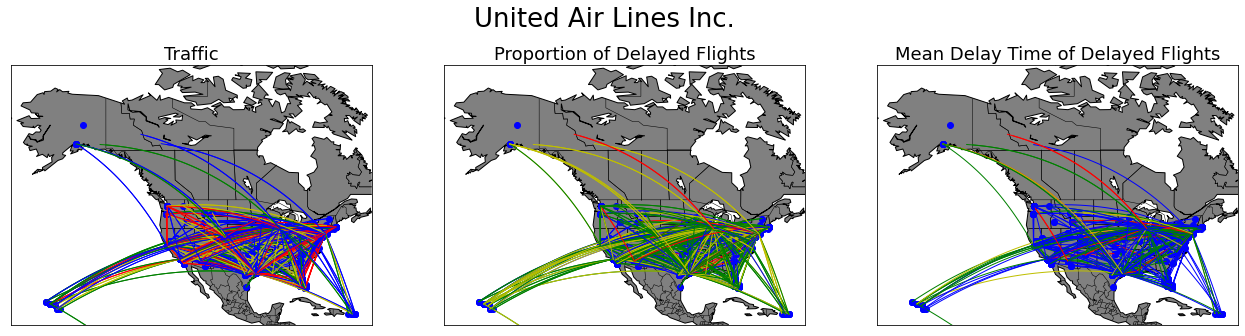

In [ ]:
traffic_delay_time_plot(df,'UA')

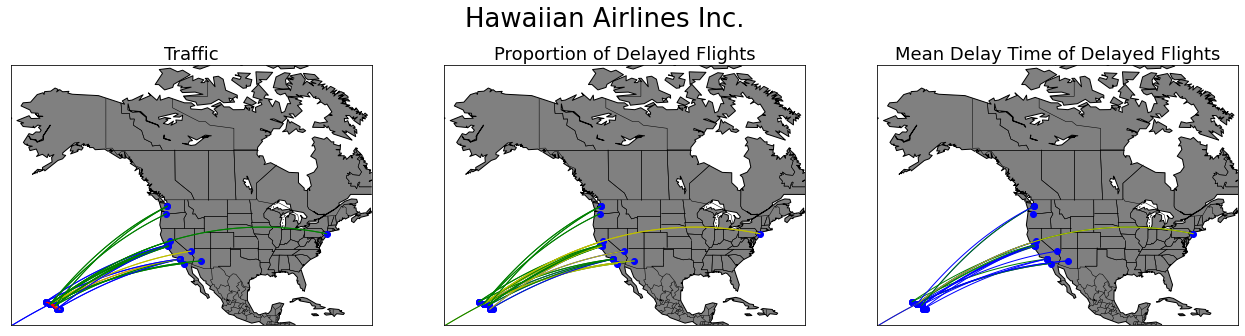

In [ ]:
traffic_delay_time_plot(df,'HA')

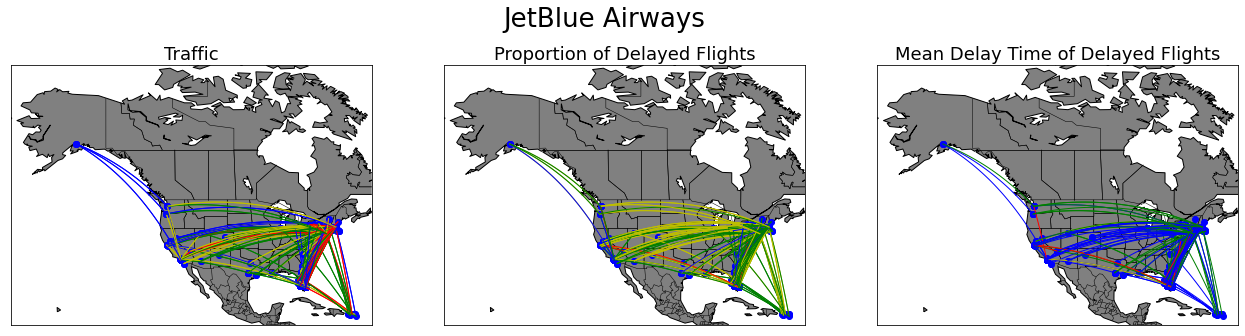

In [ ]:
traffic_delay_time_plot(df,'B6')

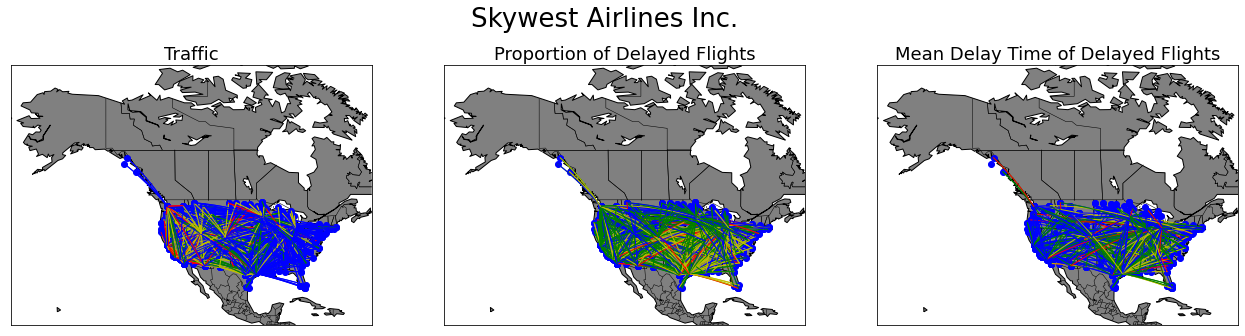

In [ ]:
traffic_delay_time_plot(df,'OO')

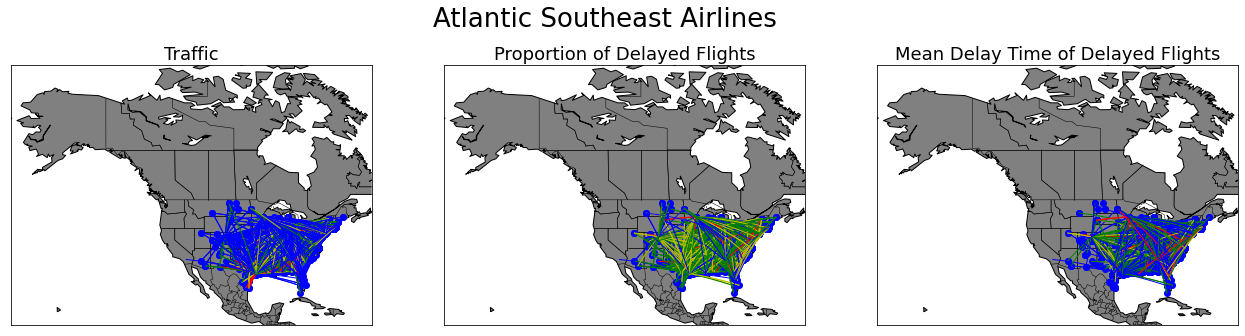

In [ ]:
traffic_delay_time_plot(df,'EV')

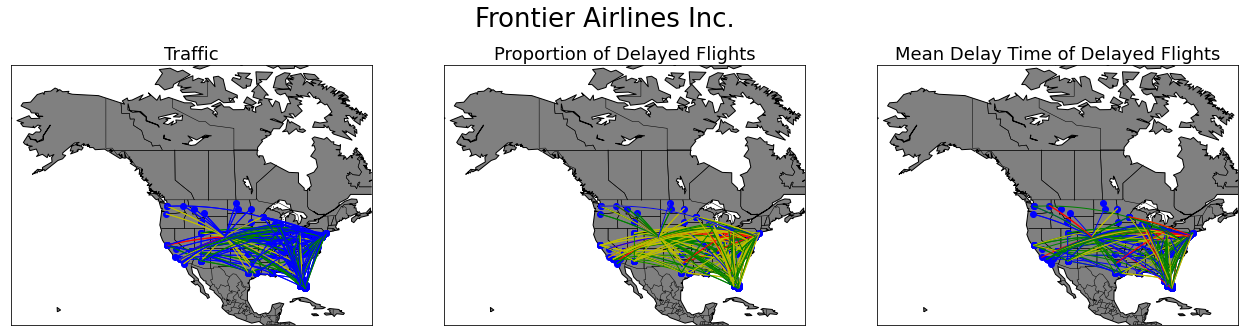

In [ ]:
traffic_delay_time_plot(df,'F9')

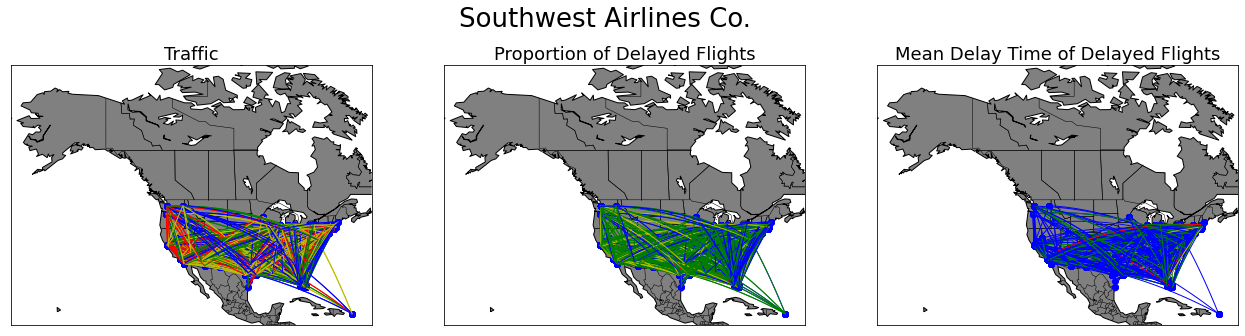

In [ ]:
traffic_delay_time_plot(df,'WN')

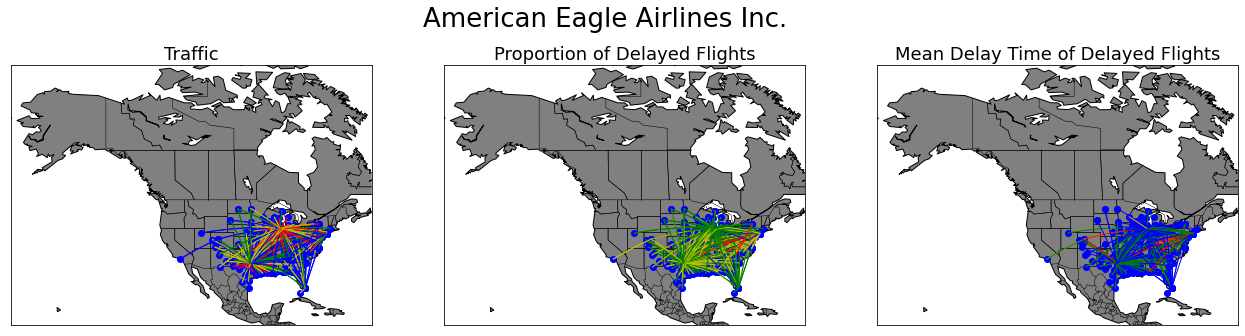

In [ ]:
traffic_delay_time_plot(df,'MQ')

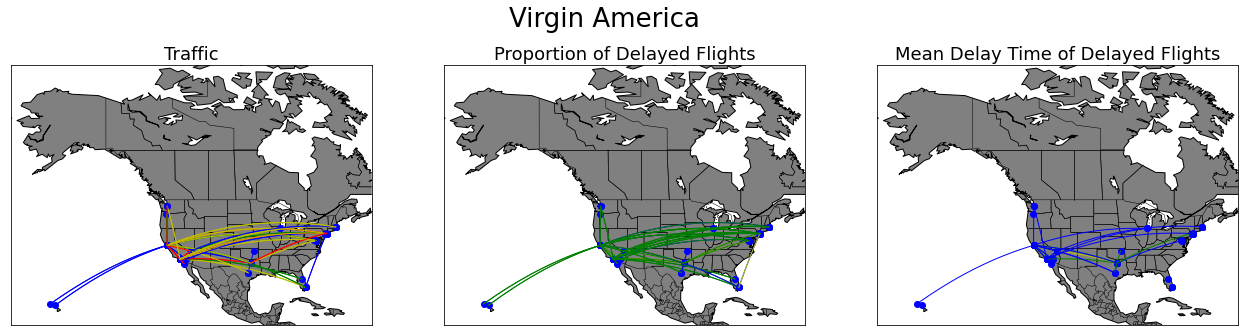

In [ ]:
traffic_delay_time_plot(df,'VX')